In [1]:
import os, glob, string, re, datetime
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Extracting the Data
Know that we have learned that we will not be able to process the data using a Spark pipeline, we will implement here a Python pipeline to read the files.

## 1 - Extracting the paths

We first have to get all the paths containing the XML files.

In [2]:
GDL = 'GDL'
JDG = 'JDG'
listFiles = []

#Go through all the files of both journals
for root, dirs, files in os.walk(GDL): 
    for file in files:
        if file.endswith('.xml'):
             listFiles.append(os.path.join(root, file))

for root, dirs, files in os.walk(JDG): 
    for file in files:
        if file.endswith('.xml'):
             listFiles.append(os.path.join(root, file))

Now that we have the path for each file in the dataset, we can work through each of them and count words. We will use the method described in **Filtering the Data.ipynb**

## 2 - Extracting the word count
Know that we have the paths for all text files, we can read the text and then clean it.

First we need the stop words.

In [3]:
stop_words = list(stopwords.words('french'))
stop_words.extend(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']',
                   '{', '}', '<', '>', '...', '-', '•', '/', '%', '«', '»', 'le',
                  'les','..','©','plus','*','``','av','p.','fr','cette','a.','v.','b.','d.',
                   'c.','e.','f.','i.','g.','h.','i.','j.','l.','m.','n.','o.','q.','r.','q.',
                   's.','t.','u.','v.','w.','x.','z.','y.',"d'un","d'une",'dm',"c'est",
                   "jusqu'au",'entre','comme','si','di','„','&',"qu'il",'_','fd',"n'a",'alors',
                   "s'est","n'est",'cs','dès','où',"jusqu'à",'déjà',"''",'|','£','®','+','-«',
                   '--','.-',"la",'---','-le','-n','î','â'])

stop_words.extend(['','-.','.,','(,','»,',').','-.','av.','».',
                      '....','..','...','.....','()','(r).','—',')-«',
                      '".','-,','(-.',')-.','(©','™','--','---','—•','•-',
                  '•','••','•••','•••','—la','ï',"'la",'•—',
                  '——','û','ê','ë','ù',"'la",'•—','——','—le',"'''","''",
                  "'","'le","'la","'i",'-on',"•'","'-","-'","a'","'de","'la",
                  "'â","aa","'-","-de","-et",'-on','-les',',,,', '——•','•-•',
                  '„„','•—•','ils','ont','tous','tout','aussi','ans',
                  'on','quelque','dont','ainsi','après','aprè',
                  'depuis','deux','dont','leurs','leur','une',
                  'fait','faite','non','oui','dit','en',' ',
                  '  ','   ','    ','     ','      ','       ','        '])
stop_words.extend(list(string.ascii_lowercase))

And preparing the dictionaries.

In [4]:
listPunct = list(string.punctuation)
listPunct.remove("'")
listPunct.remove("-")
#we do not want to stick together all the words that
#have an apostrophe (l'armée should not become larmée)
stopDict = dict(zip(listPunct,['']*len(listPunct)))
#We want to break apart words with "'" and also replace some
#random characters that we saw appeared in the text
stopDict["'"] = ' '
stopDict["•"] = ''

We also need a constant which tells us how many of the most frequent words we take.

In [5]:
numMostFreq = 3000

And then we can go through the list to extract the data in each file. We also set a counter to see how long it takes.

We first extract the data in 43 different dataframes, otherwise the algorithm's complexity is too high and the process is endless.

In [6]:
total = len(listFiles)
allText = []

In [8]:
for idx, file in tqdm(enumerate(listFiles)):   
    #find the date at which the article is published.
    date = pd.to_datetime(file[4:11])
    #Open the XML
    f = open(file,'r')
    soupArticle = BeautifulSoup(f,'lxml')
    f.close()
    
    #Extracting the entire text from the XML
    Article = []
    for ft in soupArticle.find_all('full_text'):
        #Here we lower each words and we remove the numbers from the text
        Article.append(re.sub(r'\d+', '', ft.text).lower())

    textArticle = ' '.join(Article)  
    
    #Cleaning and counting
    for k,v in stopDict.items():
        textArticle = textArticle.replace(k,v)

    dictCounter = [wordsDict for wordsDict in textArticle.split(' ') if wordsDict not in stop_words]
    countDict = Counter(dictCounter).most_common(numMostFreq+idx)
    
    #Transofming to a dataframe
    df = pd.DataFrame(countDict).transpose()
    df.columns = df.loc[0]
    df.drop(0,inplace=True)
    df.index = [date]
    allText.append(df)
    
    if idx > 0:
        if idx%50 == 0:
            dfAllText = pd.concat(allText,axis=0)
            dfAllText.to_csv('4_Data/Part_'+str(idx)+'.csv')
            del allText
            allText = []
  

4335it [11:33:20, 22.15s/it]


In [9]:
dfAllText.to_csv('4_Data/Part_end.csv')

Now that we have all the separate dataframes we can implement a function to concatenate them together.

In [2]:
csvFiles = []

for root, dirs, files in os.walk('4_Data'): 
    for file in files:
        if file.endswith('.csv'):
             csvFiles.append(pd.read_csv(os.path.join(root, file),
                                         index_col=0))

And now we can concatenate all of the separate DataFrames!

In [3]:
dfFinal = pd.concat(csvFiles,axis=0)

Now we look at the results!

In [4]:
print('Number of words : ',dfFinal.shape[1])
origShape = dfFinal.shape 
dfFinal.head()

Number of words :  275577


,----,-----,------,-------,--------,---------,----------,-----------,------------,-------------,...,„„«,„„»,„„„,„„„„,€,™-,™»,™—,™™,™™»
1806-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1806-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1806-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have a lot of words, as we saw before, we still have a lot of unwanted words and random punctuations signs that we were not able to remove during the cleaning.

In [6]:
dfFinal.columns

Index(['----', '-----', '------', '-------', '--------', '---------',
       '----------', '-----------', '------------', '-------------',
       ...
       '„„«', '„„»', '„„„', '„„„„', '€', '™-', '™»', '™—', '™™', '™™»'],
      dtype='object', length=275577)

# First Cleaning Steps

We will begin by performing a little bit of rough cleaning before going into custom NLP cleaning.

In [7]:
sumWords = dfFinal.sum(axis=0)

First we decide to remove all the words that are only present once in the dataset, as they shurely belong to either random characters or, misspells, and they do not contain a lot of information about the rest of the dataset.

In [13]:
print('Words that will be removed')
dfFinal.columns[(sumWords<2).values][20:40]

Words that will be removed


Index(['--j-«-—', '--mettre', '--pasteur', '--présente', '--quant',
       '--quelques', '--r', '--tejournaldesdébatsfaittopsles', '--ëphémérides',
       '--—les', '--——-v', '--™', '-a-genevjï', '-a-js-hs', '-accepter',
       '-accepté', '-accumulés', '-achats', '-actuel', '-actuellement'],
      dtype='object')

In [14]:
print('Before the removal of absent words: ', dfFinal.shape)
print('Number of columns that will be removed: ',(sumWords<2).sum())
dfFinal.drop(dfFinal.columns[(sumWords<2).values],axis=1,inplace=True)
print('After the cleaning: ', dfFinal.shape)

Before the removal of absent words:  (4351, 275577)
Number of columns that will be removed:  62657
After the cleaning:  (4351, 212920)


And we also see that we have two indexes per month, therefore we can groupby. 

In [15]:
dfFinal = dfFinal.fillna(0)
year = dfFinal.groupby(by='index',level=0)

And aggregate per year.

In [16]:
yearData = year.agg(sum)
yearData.head()
yearData.shape

(2351, 212920)

Setting the index in datetime to be able to plot dates.

In [17]:
yearData.index = pd.to_datetime(yearData.index)
yearIndex = yearData.index

In [27]:
sumYear = yearData.sum(axis=1)

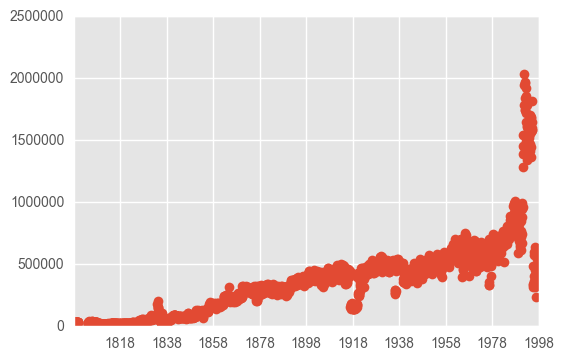

In [28]:
plt.plot_date(yearIndex,sumYear.values)

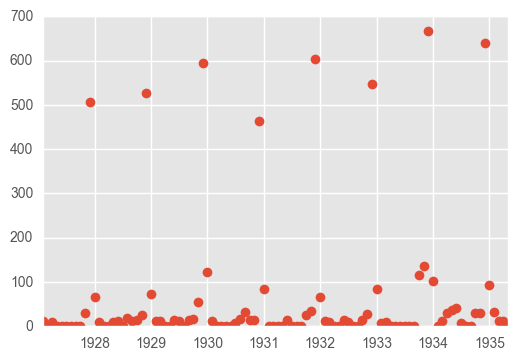

In [18]:
plt.plot_date(yearIndex[1500:1600],yearData['noël'].values[1500:1600])

### Cleaning Steps

To facilitate the transfer of data between steps we will do most of the cleaning here.

1. Removal words of two letters

In [19]:
print('Shape before the removal :', yearData.shape)
colLength = yearData.columns.map(lambda x: len(x))
print('We will remove ', len(colLength[colLength<3]),' columns')
yearData = yearData.drop(yearData.columns[colLength<3],axis=1)
print('Shape after removal : ',yearData.shape)

Shape before the removal : (2351, 212920)
We will remove  1248  columns
Shape after removal :  (2351, 211672)


Let's take a look at the minimum number of times one word appears each year.

In [20]:
yearData[yearData>0].min(axis=1)

1798-02-01     1.0
1798-03-01     2.0
1798-04-01     2.0
1798-05-01     2.0
1798-06-01     2.0
1798-07-01     2.0
1798-08-01     3.0
1798-09-01     2.0
1798-10-01     3.0
1798-11-01     3.0
1798-12-01     3.0
1799-01-01     2.0
1799-02-01     2.0
1799-03-01     3.0
1799-04-01     2.0
1799-05-01     3.0
1799-06-01     2.0
1799-07-01     2.0
1799-08-01     3.0
1799-09-01     2.0
1799-10-01     3.0
1799-11-01     3.0
1799-12-01     3.0
1804-01-01     1.0
1804-02-01     1.0
1804-03-01     1.0
1804-04-01     2.0
1804-05-01     3.0
1804-06-01     3.0
1804-07-01     3.0
              ... 
1995-07-01    15.0
1995-08-01    16.0
1995-11-01    18.0
1995-12-01    27.0
1996-01-01    29.0
1996-02-01    19.0
1996-03-01    15.0
1996-04-01    28.0
1996-05-01    19.0
1996-06-01    31.0
1996-07-01    22.0
1996-08-01    28.0
1996-09-01    30.0
1996-10-01    18.0
1996-11-01    11.0
1996-12-01    16.0
1997-01-01    23.0
1997-02-01    25.0
1997-03-01    26.0
1997-04-01    27.0
1997-05-01    26.0
1997-06-01  

We can see that by taking more and more words over the years we were able to capture a very large part of the long tail distribution!

### The columns that begin by '-'

Because we wanted to keep words such as week-end, we have a certain number of columns that start with '-' and a word, we will remove the dash.

In [21]:
colName = yearData.columns.map(lambda x: x[1:] if str(x).startswith('-') else x)
yearData.columns = colName

For the ones that end with a dash.

In [22]:
endNames = yearData.columns.map(lambda x: x[1:] if str(x).endswith('-') else x)
yearData.columns = endNames

And we groupby.

In [24]:
print('Shape Before Groupby :', yearData.shape)
dfFinal1 = yearData.groupby(by=yearData.columns,axis=1,level=0).agg(sum)
print('Shape Before Groupby :', yearData.shape)

Shape Before Groupby : (2351, 211672)
Shape Before Groupby : (2351, 211672)


In [28]:
print('Shape After Groupby: ',dfFinal1.shape)

Shape After Groupby:  (2351, 209401)


### Dealing with adverbs

We will group words with theit adverb (word and word + ement)

In [26]:
adverbs = dfFinal1.columns.map(lambda x: x[:-5] if str(x).endswith('ement') else x)
dfFinal1.columns = adverbs

And another groupby

In [27]:
print('Shape Before Groupby :', dfFinal1.shape)
dfFinal2 = dfFinal1.groupby(by=dfFinal1.columns,axis=1,level=0).agg(sum)
print('Shape Before Groupby :', dfFinal2.shape)

Shape Before Groupby : (2351, 209401)
Shape Before Groupby : (2351, 209043)


### Merging singular and plural words

As we were not satisfied by the NLTK work on the french language, we will implement our own small algorithm to merge similar words together. We start were merging singular and plural words.

In [29]:
wordCountMontClean2 = dfFinal2.copy()
#Getting the words
columnNames = wordCountMontClean2.columns.map(lambda x: str(x))

Let's look up a few of the column titles.

In [37]:
columnNames[340:360]

array(['abattoir', 'abattoirs', 'abattre', 'abattu', 'abattucci',
       'abattue', 'abattues', 'abattus', 'abatucci', 'abauzit', 'abayc',
       'abaye', 'abayes', 'abazzia', 'abb', 'abb-sécheron', 'abba',
       'abba-garima', 'abbadia', 'abbadie'], dtype=object)

As we can see, the plural of a word comes normally just after it's singular, we therefore do not have to check all of the other words for plurals.

In [39]:
sing = []
plural = []
for i in range(len(columnNames)):
    col = columnNames[i]
    colPlur = col+'s'
    colPlurX = col+'x'
    if (i+5) > (len(columnNames) - 1):
        lastEl =  len(columnNames) - 1
    else:
        lastEl = i+5
    for plur in columnNames[i:lastEl]:
        if (colPlur == plur) or (colPlurX == plur):
            sing.append(col)
            plural.append(plur)

print('Number of Singular-Plural word pairs : ', len(dict(zip(sing,plural))))
#We have to remove the jouis and jouiss pairs because, jouis will already be removed with the joui pair
#pluralWords.pop(1329)
singPlurDict = dict(zip(plural,sing))
print(sing[20:27])
print(plural[20:27])

Number of Singular-Plural word pairs :  15708
['abkhaze', 'able', 'aboi', 'abolie', 'abolitioniste', 'abolitionniste', 'abominable']
['abkhazes', 'ables', 'abois', 'abolies', 'abolitionistes', 'abolitionnistes', 'abominables']


Now that we have that we can replace the column names and then groupby so that we merge the data from the two words.

In [40]:
wordCountMontClean2.rename(columns = singPlurDict,inplace=True)
cleanData = wordCountMontClean2.groupby(by=wordCountMontClean2.columns,axis=1,level=0).agg(sum)

Now we look at the masculine and feminine version of words and of the verbs and their infinitif.

In [41]:
newCol = cleanData.columns.values

In [43]:
fem = []
masc = []

for i in range(len(newCol)):
    col = newCol[i]
    colfem= col+'e'
    infVerb = col+'r'
    if (i+5) > (len(newCol) - 1):
        lastEl =  len(newCol) - 1
    else:
        lastEl = i+5
    for plur in newCol[i:lastEl]:
        if (colfem == plur) or (infVerb == plur):
            masc.append(col)
            fem.append(plur)

dictFM = dict(zip(masc,fem))
print('Number of fem singular, verbs word pairs : ', len(dictFM))
print(masc[20:27])
print(fem[20:27])

Number of fem singular, verbs word pairs :  9240
['able', 'aboli', 'aboli', 'abondant', 'abonde', 'abonnem', 'abonné']
['abler', 'abolie', 'abolir', 'abondante', 'abonder', 'abonneme', 'abonnée']


And we groupby again.

In [44]:
cleanData.rename(columns = dictFM,inplace=True)
cleanData1 = cleanData.groupby(by=cleanData.columns,axis=1,level=0).agg(sum)

Let's take a look at the verbs.

In [45]:
verb = []
conj = []

for i in range(len(cleanData1.columns)):
    col = cleanData1.columns[i]
    infVerb = col[:-1]+'er'
    if (i+5) > (len(cleanData1.columns) - 1):
        lastEl =  len(cleanData1.columns) - 1
    else:
        lastEl = i+5
    for plur in cleanData1.columns[i:lastEl]:
        if (infVerb == plur):
            verb.append(col)
            conj.append(plur)

dictVC = dict(zip(verb,conj))
print('Number of fem singular, verbs word pairs : ', len(dictVC))
print(masc[50:57])
print(fem[50:57])

Number of fem singular, verbs word pairs :  963
['abuse', 'abusiv', 'abyssin', 'accabl', 'accable', 'accablé', 'accam']
['abuser', 'abusive', 'abyssine', 'accable', 'accabler', 'accablée', 'accame']


In [46]:
cleanData1.rename(columns = dictVC,inplace=True)

We also want to replace "participe passé" feminine to the infinitif verb.

In [47]:
print(cleanData1.columns[np.chararray.endswith(cleanData1.columns.values.astype(str),'ée')])

Index(['abaissée', 'abandonnée', 'abfentée', 'abforbée', 'abonnée', 'abordée',
       'abreuvée', 'abritée', 'abrogée', 'abrégée',
       ...
       'évadée', 'évaluée', 'éveillée', 'évitée', 'évoluée', 'évoquée',
       'ôméée', 'ôuiéée', '—méditerranée', '—sodée'],
      dtype='object', length=1953)


In [48]:
cleanData1.columns = cleanData1.columns.map(lambda x: x[:-2]+'er' if str(x).endswith('ée') else x)

And then we can groupby again.

In [49]:
cleanData2 = cleanData1.groupby(by=cleanData1.columns,axis=1,level=0).agg(sum)
cleanData2.shape

(2351, 182601)

Let's try to group together verbs and their conjugaisons.

In [50]:
colClean2 = cleanData2.columns.values

In [51]:
verbList = []
verbFamily = []
for i in range(len(colClean2)):
    if colClean2[i].endswith('er'):
        wordClean = colClean2[i]
        word = colClean2[i][:-2]
        for j in range(i-4,i+4):
            if j == i:
                pass
            
            otherWord = colClean2[j]
            if ((otherWord[:len(word)] == word) and ((otherWord[-2:] == 'en') 
                | (otherWord[-3:] == 'ent')  | (otherWord[-3:] == 'era')  
                | (otherWord[-3:] == 'ait')  | (otherWord[-3:] == 'ant') 
                | (otherWord[-2:] == 'és') | (otherWord[-4:] == 'eant') 
                | (otherWord[-2:] == 'es') | (otherWord[-2:] == 'ai'))):
                verbList.append(wordClean)
                verbFamily.append(otherWord)

print('We have identified: ', len(verbList), 'Verbs to put together')
dictVerbFamily = dict(zip(verbFamily,verbList))
print(verbList[20:27])
print(verbFamily[20:27])

We have identified:  4779 Verbs to put together
['abriter', 'abroger', 'abréger', 'abréger', 'absenter', 'absenter', 'absorber']
['abritant', 'abrogeant', 'abrégerai', 'abrégerait', 'absentent', 'absentera', 'absorbait']


And we can put these columns together.

In [52]:
cleanData2.rename(columns = dictVerbFamily,inplace=True)

And another GroupBy.

In [53]:
cleanDataVerb = cleanData2.groupby(by=cleanData2.columns,axis=1,level=0).agg(sum)
cleanDataVerb.shape

(2351, 177907)

We can see that our dataset is still very large, but those operations manage to reduce its size without loosing information!

Now that we have tried not to loose too much of information by trying to merge words that have the same meaning we can start doing some more direct actions.

In [57]:
print('Number of unique words before grouping: ', dfFinal.shape[1])
print('Number of unique words after grouping: ', cleanDataVerb.shape[1])

Number of unique words before grouping:  212920
Number of unique words after grouping:  177907


### Dealing with missing data

One of the problem that we have for our dataset is that there are some months were a word count is missing (for some words). When importing the data we had to choose a frequency limit, and we did not save words that appeared below this limit. Due to the long tail distribution of the data words that have a fequency near the limit can be above it in one month and below it in the other month, therefore we will have a lot of missing values for this word.

For furutre predictions and visualization we are more interested in the general shape of the time series, and not the few months in between where the word is missing, therefore it could be interesting to interpolate the missing data.

But there are also words that are only in present only in a few months and not more. We do not need these words as they are not interesting to predict and do not bring an interesting visualizations.

Due to the fact that we have made some aggregations in the previous steps, we assume that removing words that do not occur very often will not loose information about the other words. We choose to remove words that only appear in 10 different months or less.

In [55]:
cleanData3 = cleanDataVerb.copy()
numMonth = cleanData3.astype(bool).sum(axis=0).values

Let's look at which words are in this situations.

In [58]:
cleanData3.columns[numMonth<10][1:50]

Index(['--------------', '---------------', '----------------',
       '-----------------', '------------------', '-------------------',
       '--------------------------------------------------------------------------',
       '---------------------------------------------------------------------------',
       '------har', '---le', '--am', '--beecham', '--bowater', '--br',
       '--broken', '--can', '--clôture', '--coca', '--courtaulds', '--de',
       '--dimanche', '--dôme', '--e', '--east', '--free', '--g', '--ii',
       '--imp', '--kloof', '--l', '--m', '--marks', '--n-', '--plessey',
       '--pots', '--rank', '--roan', '--rolls', '--s', '--sel', '--slater',
       '--st', '--tampax', '--tesco', '--tube', '--union', '--unit',
       '--vickers', '--volume'],
      dtype='object')

In [59]:
cleanData3.columns[numMonth<10][1000:1050]

Index(['actionprime', 'actionsdejouissanceducanaldu', 'actionsjura-simplon',
       'actionsou', 'actious', 'actium', 'activite', 'actlvlte', 'acto',
       'acton', 'actoteatro', 'actouest-suiss', 'acts', 'actu', 'actual',
       'actualisation', 'actualite', 'actuariels', 'actue', 'actueles',
       'actuellede', 'actère', 'acu', 'acuminariatique', 'acun', 'acunto',
       'acupuncture', 'acv', 'acy', 'acéré', 'acétate', 'acétique',
       'acétylcholine', 'acùt', 'acût', 'ad', 'ad-', 'ad-astra', 'ad-hoc',
       'ad-intérim', 'ada-agamus', 'adage', 'adalberl', 'adalberto',
       'adalgisa', 'adalr', 'adam-benjamin', 'adam-louis', 'adamec',
       'adamello'],
      dtype='object')

In [61]:
cleanData3.columns[numMonth<10][900:950]

Index(['acliard', 'aclif', 'aclivité', 'acloque', 'aclrice', 'acluclle',
       'acluelle', 'acmvveveyn', 'acmvveveyp', 'acné', 'acolade', 'acoliar',
       'acollas', 'acolytes', 'acom', 'acommission', 'acomp', 'acon', 'acon-',
       'aconit', 'aconitine', 'aconnex', 'aconte-', 'acores', 'acoust',
       'acoûté', 'acquadro', 'acquainted', 'acquapendente', 'acquarelle',
       'acqueducs', 'acquerra', 'acquerraient', 'acquerrait', 'acquerront',
       'acques-', 'acqui', 'acquiesc', 'acquiescer', 'acquiescerons',
       'acquiescé', 'acquiesça', 'acquife', 'acquill', 'acquiller', 'acquin',
       'acquired', 'acquisilion', 'acquiter', 'acquitta'],
      dtype='object')

We can see that these are not very important words, and as they do not have many datapoints we can easily remove them.

In [62]:
print('Before word aggregation : ', dfFinal.shape)
print('Before the removal of absent words: ', cleanData3.shape)
cleanData3.drop(cleanData3.columns[numMonth < 10].values,axis=1,inplace=True)
print('After the cleaning: ', cleanData3.shape)

Before word aggregation :  (4351, 212920)
Before the removal of absent words:  (2351, 177907)
After the cleaning:  (2351, 43243)


We will also remove words that are only present less than ten times in the entire dataset, as they do not represent a very strong signal and will not be very useful for visualization or prediction.

In [65]:
sumWords = cleanData3.sum(axis=0)

In [66]:
print('Before the removal of absent words: ', cleanData3.shape)
print('Number of columns that will be removed: ',(sumWords<10).sum())
cleanData3.drop(cleanData3.columns[(sumWords<15).values],axis=1,inplace=True)
print('After the cleaning: ', cleanData3.shape)

Before the removal of absent words:  (2351, 43243)
Number of columns that will be removed:  0
After the cleaning:  (2351, 43176)


Let's take a look at our cleaning

In [67]:
cleanData3.head()

,,-,--,---,----,-----,------,-------,--------,---------,...,—turin,—une,—union,—vingt-quatrième,—vingt-troisième,—voici,—vous,———,————,„„„
1798-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-05-01,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We see that there are still random signes that we were not able to remove we will do that now.

In [72]:
cleanData3.columns[0:47]

Index(['', '-', '--', '---', '----', '-----', '------', '-------', '--------',
       '---------', '----------', '-----------', '------------', '--i',
       '-arbr', '-c', '-d', '-genève', '-i', '-le', '-s', '-s-', '-tarifs',
       '-téléphone', '-—', 'a-', 'a-b', 'a-bu', 'a-ce', 'a-k', 'a-l-il',
       'a-l-on', 'a-t', 'a-t-elle', 'a-t-il', 'a-t-on', 'aa-', 'aaa', 'aac',
       'aach', 'aacom', 'aal', 'aaland', 'aandoz', 'aap', 'aar', 'aar-tessin'],
      dtype='object')

In [73]:
cleanData3.drop(cleanData3.columns[0:47],axis=1,inplace=True)

We also have the bizarre dash that we can quickly take care of again

In [74]:
cleanData3.columns[np.chararray.startswith(cleanData3.columns.values.astype(str),'—')]

Index(['—-a', '—-la', '—-le', '—-on', '—-—', '—adopté', '—alu', '—am',
       '—annecy', '—au',
       ...
       '—trois', '—turin', '—une', '—union', '—vingt-quatrième',
       '—vingt-troisième', '—voici', '—vous', '———', '————'],
      dtype='object', length=105)

In [75]:
cleanData3.columns = \
cleanData3.columns.map(lambda x: x[1:] if x.startswith('—') else x)

In [76]:
print('Before: ',cleanData3.shape)
cleanData4 = cleanData3.groupby(by=cleanData3.columns,axis=1,level=0).agg(sum)
print('Before: ',cleanData4.shape)

Before:  (2351, 43129)
Before:  (2351, 43051)


In [78]:
cleanData4.head()

,-a,-la,-le,-on,-—,aarau,aarberg,aarbourg,aarg,aarhus,...,œil,œillet,œquo,œrlikon,œuf,œur-,œuvre,——,———,„„„
1798-02-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-04-01,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1798-06-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It looks like the dataset is a bit more cleaned up!

In [79]:
cleanData4.to_csv('3kplusWordMonth.csv')